In [ ]:
# 원본 코드


import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


    plt.imshow(img)
    plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    print('회전 전')
    plt.imshow(thresh_cv, cmap='gray')
    plt.show()


    # Hough Transition 회전 보정
    # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # np.sort(lines)[::-1]

    print('line 개수 = ', len(lines))

    if lines is not None:
        lines = lines.reshape([-1, 2])
        # for line in lines[:]:
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            # hough line 그리는 함수
            # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


        plt.imshow(img)
        plt.show()


        # 회전 각도
        # print(lines[:, 1])
        theta_avg = np.average(lines[:10, 1])
        # theta_avg = np.average(lines[:20, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
        print('angle : ', angle)


        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


        print('회전 후')
        plt.imshow(thresh_cv, cmap='gray')
        plt.show()

        return thresh_cv


# 2
# 점자 좌표 탐색
def find_location(thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 중심점
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])

        center = np.append(center, np.array([[cx, cy]]), axis=0)

    return center, center_list



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0])
    classify_y, standard_y = standard(center[:, 1])
  

    # y좌표 간격 통일
    dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist


    # x 좌표 간격 통일
    # 가능한 모든 x 좌표 구하기 
    x_list = find_x(dist, standard_x)


    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)


    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)


    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)

      num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 1, 4)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > 10: # 10은 내가 임의로 정함 ( 원래는 정확한 점 사이의 간격을 고려해서 넣어야 함 )
        line.append([i])
      else:
        line[-1].append(i)

  avg = [int(np.average(i)) for i in line]

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] >= int(1.7 * dist)):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  # 반복 횟수
  i = 1
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      new_x = all_x[-1] + (dist * 1.8)

    all_x.append(int(new_x))


    # 마지막 좌표
    # 0.25는 임의로 잡은 숫자
    # if new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25):
    if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]: # 무한 반복 방지
      if i % 2 == 1:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    i += 1

  return all_x




# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경
def changeStandard_x(dist, standard, x_list):

  for i in range(len(standard)):
    for j in x_list:
      if standard[i] < j - (dist * 0.25):
        break
      else:
        if standard[i] < j + (dist * 0.25):
          standard[i] = j

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])








# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])


    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))


    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list = find_location(thresh_cv)

  # 흰색 배경
  blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
  draw = np.full(thresh_cv.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')


logic('C:\\Users\\HwaJong\\Desktop\\test\\new.jpg')  


이미지 전처리 -> pre_processing()


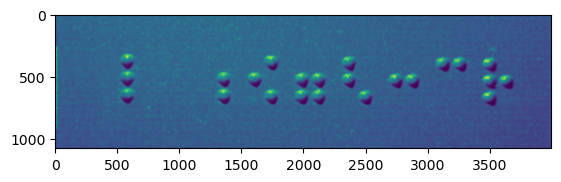


 점자 좌표 탐색 -> find_location()

 점자 좌표 보정 -> modify_location()


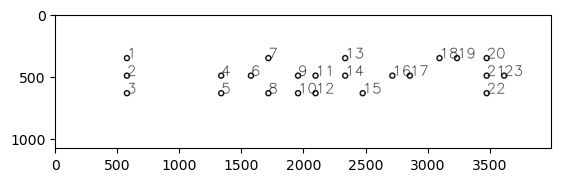


 점자 추출 -> find_braille()


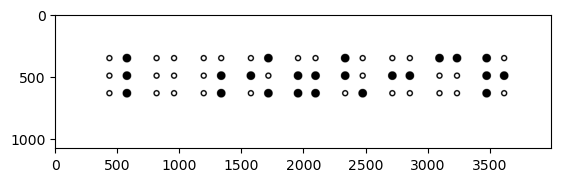

(0, 0, 0, 1, 1, 1)
(0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 1, 1)
(0, 1, 0, 1, 0, 1)
(0, 1, 1, 0, 1, 1)
(1, 1, 0, 0, 0, 1)
(0, 1, 0, 0, 1, 0)
(1, 0, 0, 1, 0, 0)
(1, 1, 1, 0, 1, 0)


In [1]:
# 중간 점자 생성 코드 수정본


import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


    plt.imshow(img)
    plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # print('회전 전')
    # plt.imshow(thresh_cv, cmap='gray')
    # plt.show()


    # Hough Transition 회전 보정
    # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # np.sort(lines)[::-1]

    # print('line 개수 = ', len(lines))

    if lines is not None:
        lines = lines.reshape([-1, 2])
        # for line in lines[:]:
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            # hough line 그리는 함수
            # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


        # plt.imshow(img)
        # plt.show()


        # 회전 각도
        # print(lines[:, 1])
        theta_avg = np.average(lines[:10, 1])
        # theta_avg = np.average(lines[:20, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
        # print('angle : ', angle)


        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


        # print('회전 후')
        # plt.imshow(thresh_cv, cmap='gray')
        # plt.show()

        return thresh_cv


# 2
# 점자 좌표 탐색
def find_location(thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 중심점
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])

        center = np.append(center, np.array([[cx, cy]]), axis=0)

    return center, center_list




# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):

    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    # dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist



    # x 좌표 간격 통일
    # 가능한 모든 x 좌표 구하기 
    x_list = find_x(dist, standard_x)



    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)



    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)



    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)

      num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 1, 4)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2: # 0.25 는 내가 임의로 정함 ( 같은 점이라고 판단할만한 범위 )
        line.append([i])
      else:
        line[-1].append(i)

  avg = [int(np.average(i)) for i in line]

  # print('line = ', line)
  # print('avg = ', avg)

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] >= int(1.7 * dist)):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  # 반복 횟수
  i = len(all_x)
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      new_x = all_x[-1] + (dist * 1.7)

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표
    # 0.25는 임의로 잡은 숫자
    # if new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25):
    if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]:   # 무한 반복 방지
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    

  return all_x




# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경
def changeStandard_x(dist, standard, x_list):

  for i in range(len(standard)):
    for j in x_list:
      if standard[i] < j + (dist * 0.25) and standard[i] > j - (dist * 0.25):
        standard[i] = j
        continue

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])








# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])




    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))



    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list = find_location(thresh_cv)

  # 흰색 배경
  blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
  draw = np.full(thresh_cv.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')

 
logic('C:\\Users\\HwaJong\\Desktop\\test\\new.jpg')  

이미지 전처리 -> pre_processing()


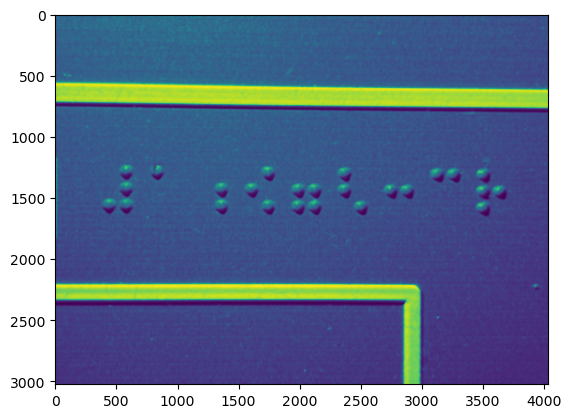


 점자 좌표 탐색 -> find_location()


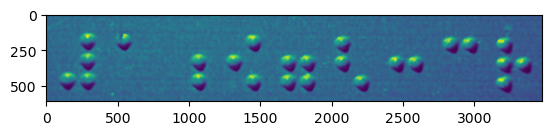

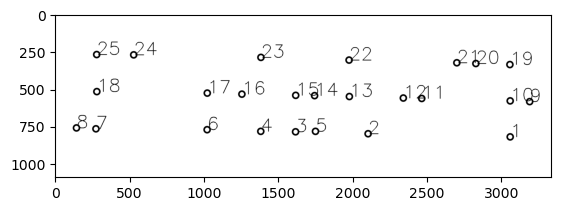


 점자 좌표 보정 -> modify_location()


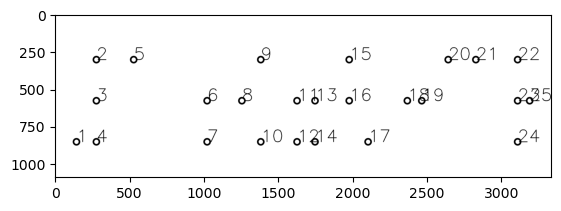


 점자 추출 -> find_braille()


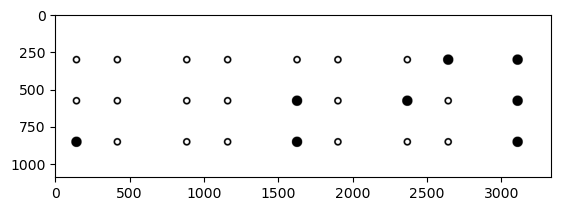

(0, 0, 1, 0, 0, 0)
(0, 0, 0, 0, 0, 0)
(0, 1, 1, 0, 0, 0)
(0, 1, 0, 1, 0, 0)
(1, 1, 1, 0, 0, 0)


In [4]:
# 이미지 자르기

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


    plt.imshow(img)
    plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # print('회전 전')
    # plt.imshow(thresh_cv, cmap='gray')
    # plt.show()


    # # Hough Transition 회전 보정
    # # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # # np.sort(lines)[::-1]

    # # print('line 개수 = ', len(lines))

    # if lines is not None:
    #     lines = lines.reshape([-1, 2])
    #     # for line in lines[:]:
    #     for line in lines[:10]:
    #         rho = line[0]
    #         theta = line[1]

    #         a = np.cos(theta)
    #         b = np.sin(theta)

    #         x0 = a*rho
    #         y0 = b*rho

    #         x1 = int(x0 + 1000*(-b))
    #         y1 = int(y0 + 1000*(a))

    #         x2 = int(x0 - 1000*(-b))
    #         y2 = int(y0 - 1000*(a))

    #         # hough line 그리는 함수
    #         # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


    #     # plt.imshow(img)
    #     # plt.show()


    #     # 회전 각도
    #     # print(lines[:, 1])
    #     theta_avg = np.average(lines[:10, 1])
    #     # theta_avg = np.average(lines[:20, 1])
    #     angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
    #     # print('angle : ', angle)


    #     # 회전 ( 정확하게 보정되진 않음 )
    #     matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
    #     thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


    #     # print('회전 후')
    #     # plt.imshow(thresh_cv, cmap='gray')
    #     # plt.show()

    #     # return thresh_cv
    #     return img, thresh_cv

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

################################
            
    # 중심점
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])


        # center_list.append([num, cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        # cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        # num += 1


    # plt.imshow(blank, cmap = 'gray')
    # plt.show()

    # print(*center_list)
    # center_list = []


###############################

    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150]


    plt.imshow(new_img)
    plt.show()


    # 비율 정해서 resize
    new_img = cv2.resize(new_img, (3337, 1091),  fy= 140 / ((max_y - min_y) / 2))


    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    center = np.empty((0, 2), int)  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 중심점
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      # if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건

      M = cv2.moments(i)

      cx = int(M['m10'] / M['m00'])
      cy = int(M['m01'] / M['m00'])


      center_list.append([cx, cy])
      center = np.append(center, np.array([[cx, cy]]), axis=0)

      cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
      cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
      num += 1


    plt.imshow(blank, cmap = 'gray')
    plt.show()

      
    return center, center_list, blank




# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):

    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    # dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist



    # x 좌표 간격 통일
    # 가능한 모든 x 좌표 구하기 
    x_list = find_x(dist, standard_x)



    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)



    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)



    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)

      num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 1, 4)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2: # 0.25 는 내가 임의로 정함 ( 같은 점이라고 판단할만한 범위 )
        line.append([i])
      else:
        line[-1].append(i)

  avg = [int(np.average(i)) for i in line]

  # print('line = ', line)
  # print('avg = ', avg)

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] >= int(1.7 * dist)):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  # 반복 횟수
  i = len(all_x)
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      new_x = all_x[-1] + (dist * 1.7)

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표
    # 0.25는 임의로 잡은 숫자
    # if new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25):
    if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]:   # 무한 반복 방지
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    

  return all_x




# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경
def changeStandard_x(dist, standard, x_list):

  for i in range(len(standard)):
    for j in x_list:
      if standard[i] < j + (dist * 0.25) and standard[i] > j - (dist * 0.25):
        standard[i] = j
        continue

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])








# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])




    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))



    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  img, thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list, new = find_location(img, thresh_cv)

  # 흰색 배경
  blank = np.full(new.shape[:], 255, dtype='uint8')
  draw = np.full(new.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\plz2.jpg')  

이미지 전처리 -> pre_processing()


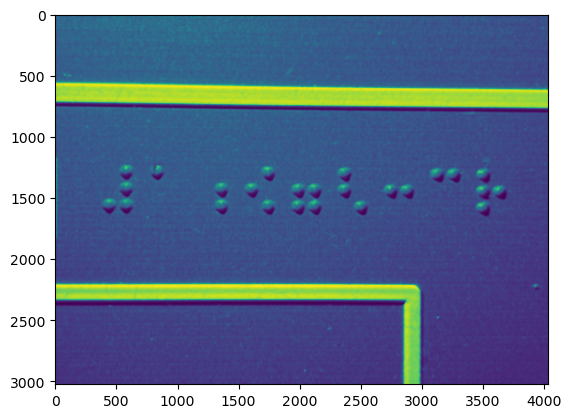


 점자 좌표 탐색 -> find_location()
자른 사진


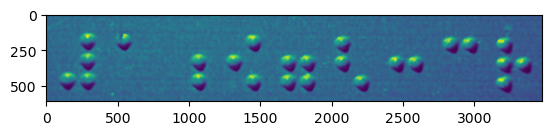

자른 사진을 배경에 합치기


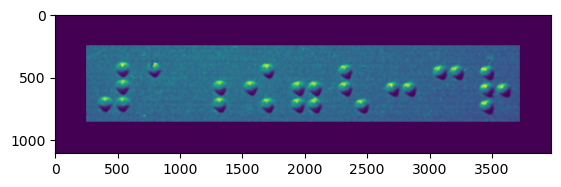

회전 후


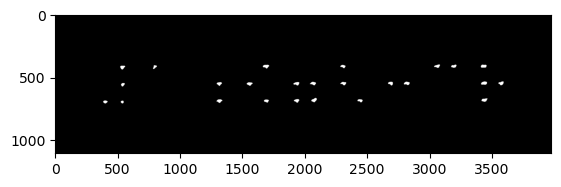

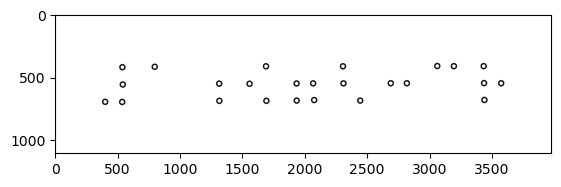


 점자 좌표 보정 -> modify_location()


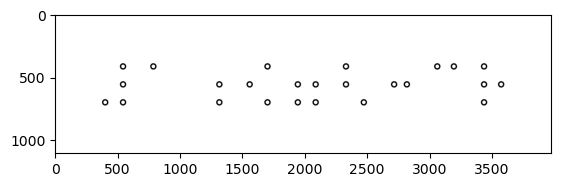


 점자 추출 -> find_braille()


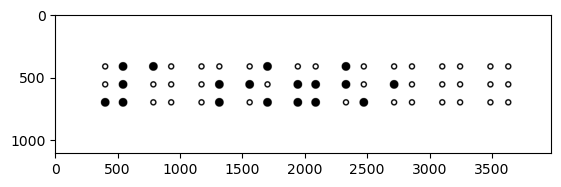

(0, 0, 1, 1, 1, 1)
(1, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 1, 1)
(0, 1, 0, 1, 0, 1)
(0, 1, 1, 0, 1, 1)
(1, 1, 0, 0, 0, 1)
(0, 1, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0)


In [6]:
# 이미지 자르기에서 회전 보정 따로 추출
# 두 번째 Contour에 != 0 조건 주석 해제
# 이미지보다 큰 배경 만들 때, 자른 이미지와 동일한 색상을 갖도록 수정

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


    plt.imshow(img)
    plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # print('회전 전')
    # plt.imshow(thresh_cv, cmap='gray')
    # plt.show()

    return img, thresh_cv





"""
2번 
resize 조절해야함
  resize 우선 생략했을 때 결과 이상
  아마 이건 3번 문제일듯
blank 크기 조절할 수 있음
"""



# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


################################ 1차로 추리기
            
    # blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])


        # center_list.append([num, cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        # cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        # num += 1

    # plt.imshow(blank, cmap = 'gray')
    # plt.show()

    # print(*center_list)
    # center_list = []


############################### 이미지 자르기


    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    # 사진 자르기
    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150].copy()

    print('자른 사진')
    plt.imshow(new_img)
    plt.show()

############################### 이미지 크게 만들기 1. 배경 만들고 붙이기

    pix = new_img[0:1, 0:1]

    # 새로 배경을 만들고, 자른 이미지를 배경의 중앙에 위치하도록

    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 255, dtype='uint8')
    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 0, dtype='uint8')
    bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), pix, dtype='uint8')

    x_offset = (bg.shape[1] - new_img.shape[1]) // 2
    y_offset = (bg.shape[0] - new_img.shape[0]) // 2

    bg[y_offset:y_offset + new_img.shape[0],
       x_offset:x_offset + new_img.shape[1]] = new_img

    print('자른 사진을 배경에 합치기')
    plt.imshow(bg)
    plt.show()


    # 합친 이미지의 배경이 동일하지 않아서 그런가 결과가 제대로 출력되지 않음
    new_img = bg


############################### 이미지 크게 만들기 2. resize ➜ 안쓰는게 나을듯


    # 자른 사진 resize
    # new_img = cv2.resize(new_img, (3337, 1091))   # 크기 정해서 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 140 / ((max_y - min_y) / 2), fy= 140 / ((max_y - min_y) / 2)) # 비율로 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 1.5, fy= 1.5) # 비율로 resize


    # print('자른 사진 resize')
    # plt.imshow(new_img)
    # plt.show()



############################### 새로운 이미지에서 처음부터 시작


    # 중심점 초기화
    center = np.empty((0, 2), int) 


    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    # 회전 보정
    thresh_cv = rotate(new_img, thresh_cv)

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # blank = np.full([thresh_cv.shape[0] + 200, thresh_cv.shape[1] + 200], 255, dtype='uint8')

 
    # 점자 번호
    num = 1
            
    for i in contours:
      # if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
      if (cv2.contourArea(i) != 0):  # 면적 기본 조건

        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])


        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        num += 1


    plt.imshow(blank, cmap = 'gray')
    plt.show()

      
    return center, center_list, blank




# 2-1

def rotate(img, thresh_cv):

    # Hough Transition 회전 보정
    # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # np.sort(lines)[::-1]

    # print('line 개수 = ', len(lines))

    if lines is not None:
        lines = lines.reshape([-1, 2])
        # for line in lines[:]:
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            # hough line 그리는 함수
            # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


        # plt.imshow(img)
        # plt.show()


        # 회전 각도
        # print(lines[:, 1])
        theta_avg = np.average(lines[:10, 1])
        # theta_avg = np.average(lines[:20, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
        # print('angle : ', angle)


        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


        print('회전 후')
        plt.imshow(thresh_cv, cmap='gray')
        plt.show()

        return thresh_cv



"""
3번에서 사용하는 메서드들이 중요
여기서 사용하는 모든 수치에 따라 결과가 다르게 나옴
"""



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):

    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    # dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist



    # x 좌표 간격 통일
    # 가능한 모든 x 좌표 구하기 
    x_list = find_x(dist, standard_x)



    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)



    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)



    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      # cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)

      num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 1, 4)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2: # 0.25 는 내가 임의로 정함 ( 같은 점이라고 판단할만한 범위 )
        line.append([i])
      else:
        line[-1].append(i)

  avg = [int(np.average(i)) for i in line]

  # print('line = ', line)
  # print('avg = ', avg)

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] >= int(1.7 * dist)):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  # 반복 횟수
  i = len(all_x)
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      new_x = all_x[-1] + (dist * 1.7)

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표
    # 0.25는 임의로 잡은 숫자
    if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]:
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    

  return all_x




# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경
def changeStandard_x(dist, standard, x_list):

  for i in range(len(standard)):
    for j in x_list:
      if standard[i] < j + (dist * 0.25) and standard[i] > j - (dist * 0.25):
        standard[i] = j
        continue

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])








# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])


    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))


    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  img, thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list, new = find_location(img, thresh_cv)

  # 흰색 배경
  blank = np.full(new.shape[:], 255, dtype='uint8')
  draw = np.full(new.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\plz2.jpg')  

이미지 전처리 -> pre_processing()

 점자 좌표 탐색 -> find_location()


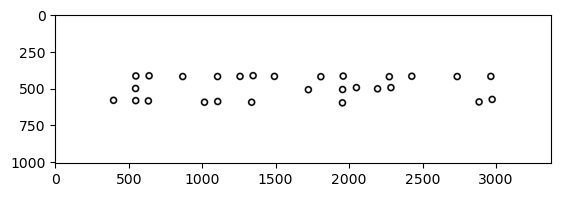


 점자 좌표 보정 -> modify_location()


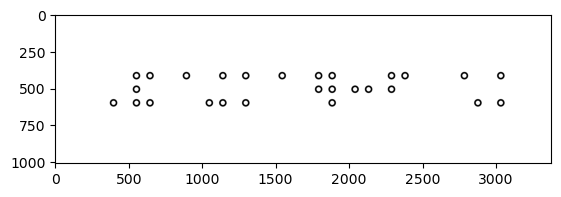


 점자 추출 -> find_braille()


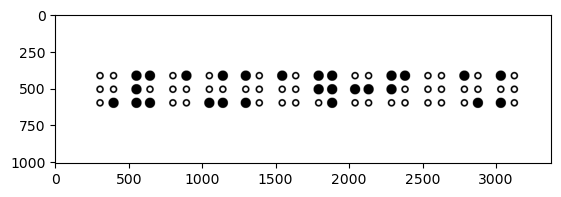

(0, 0, 0, 0, 0, 1)
(1, 1, 1, 1, 0, 1)
(0, 0, 0, 1, 0, 0)
(0, 0, 1, 1, 0, 1)
(1, 0, 1, 0, 0, 0)
(1, 0, 0, 0, 0, 0)
(1, 1, 0, 1, 1, 1)
(0, 1, 0, 0, 1, 0)
(1, 1, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 0)
(1, 0, 0, 0, 0, 1)
(1, 0, 1, 0, 0, 0)


In [3]:
# 이전 코드에서 점자 판단이 잘 이루어지지 않는 부분 수정
# 첫 번째 줄 생성 조건 변경

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


#     plt.imshow(img)
#     plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # print('회전 전')
    # plt.imshow(thresh_cv, cmap='gray')
    # plt.show()

    return img, thresh_cv



"""
2번 
resize 조절해야함
  resize 우선 생략했을 때 결과 이상
  아마 이건 3번 문제일듯
blank 크기 조절할 수 있음
"""


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

################################ 1차로 추리기
            
    # blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])


        # center_list.append([num, cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        # cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        # num += 1

    # plt.imshow(blank, cmap = 'gray')
    # plt.show()

    # print(*center_list)
    # center_list = []

############################### 이미지 자르기

    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    # 사진 자르기
    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150].copy()

#     print('자른 사진')
#     plt.imshow(new_img)
#     plt.show()

############################### 이미지 크게 만들기 1. 배경 만들고 붙이기

    pix = new_img[0:1, 0:1]

    # 새로 배경을 만들고, 자른 이미지를 배경의 중앙에 위치하도록

    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 255, dtype='uint8')
    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 0, dtype='uint8')
    bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), pix, dtype='uint8')

    x_offset = (bg.shape[1] - new_img.shape[1]) // 2
    y_offset = (bg.shape[0] - new_img.shape[0]) // 2

    bg[y_offset:y_offset + new_img.shape[0],
       x_offset:x_offset + new_img.shape[1]] = new_img

#     print('자른 사진을 배경에 합치기')
#     plt.imshow(bg)
#     plt.show()


    # 합친 이미지의 배경이 동일하지 않아서 그런가 결과가 제대로 출력되지 않음
    new_img = bg

############################### 이미지 크게 만들기 2. resize ➜ 안쓰는게 나을듯

    # 자른 사진 resize
    # new_img = cv2.resize(new_img, (3337, 1091))   # 크기 정해서 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 140 / ((max_y - min_y) / 2), fy= 140 / ((max_y - min_y) / 2)) # 비율로 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 1.5, fy= 1.5) # 비율로 resize


    # print('자른 사진 resize')
    # plt.imshow(new_img)
    # plt.show()

############################### 새로운 이미지에서 처음부터 시작

    # 중심점 초기화
    center = np.empty((0, 2), int) 

    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    # 회전 보정
    thresh_cv = rotate(new_img, thresh_cv)

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # blank = np.full([thresh_cv.shape[0] + 200, thresh_cv.shape[1] + 200], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      # if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
      if (cv2.contourArea(i) != 0):  # 면적 기본 조건

        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()
      
    return center, center_list, blank



# 2-1
# 회전 보정
def rotate(img, thresh_cv):

    # Hough Transition 회전 보정
    # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # np.sort(lines)[::-1]

    # print('line 개수 = ', len(lines))

    if lines is not None:
        lines = lines.reshape([-1, 2])
        # for line in lines[:]:
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            # hough line 그리는 함수
            # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


        # plt.imshow(img)
        # plt.show()


        # 회전 각도
        # print(lines[:, 1])
        theta_avg = np.average(lines[:10, 1])
        # theta_avg = np.average(lines[:20, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
        # print('angle : ', angle)


        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


#         print('회전 후')
#         plt.imshow(thresh_cv, cmap='gray')
#         plt.show()

        return thresh_cv



"""
3번에서 사용하는 메서드들이 중요
여기서 사용하는 모든 수치에 따라 결과가 다르게 나옴
"""



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):

    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    # dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist


    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    x_list = find_x(dist, standard_x)
    

    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)


    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)


    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    # num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      # cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)
      # num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 1, 4)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2: # 0.25 는 내가 임의로 정함 ( 같은 점이라고 판단할만한 범위 )
        line.append([i])
      else:
        line[-1].append(i)

  # avg = [int(np.average(i)) for i in line]
  avg = [i[0] for i in line]

  # print('line = ', line)
  # print('avg = ', avg)

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] > standard[2] - standard[1]):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  i = len(all_x)   # 반복 횟수
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      new_x = all_x[-1] + (dist * 1.7)

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
    # 0.25는 임의로 잡은 숫자
    if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]:
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    
  return all_x



"""
3-3 에서 잘못된 좌표로 수정되거나
수정이 안되는 문제로 인해 4번 결과가 이상함
"""

# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):

  for i in range(len(standard)):
    new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
    num = min(new)
    standard[i] = num + standard[i] if num + standard[i] in x_list else standard[i] - num

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])





"""
결과가 좋지 않아도 4번은 웬만하면 문제가 없다
3번에서 잘못된 처리를 해서 4번이 잘못된 결과를 출력
"""


# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])


    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))


    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  img, thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list, new = find_location(img, thresh_cv)

  # 흰색 배경
  blank = np.full(new.shape[:], 255, dtype='uint8')
  draw = np.full(new.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\plz4.jpg')  

이미지 전처리 -> pre_processing()

 점자 좌표 탐색 -> find_location()


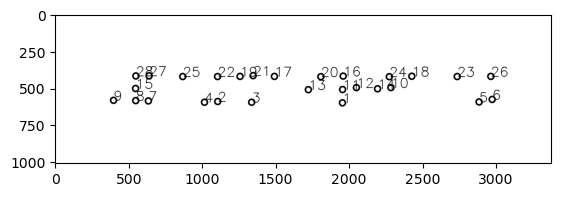



[1, 1956] [2, 1107] [3, 1338] [4, 1017] [5, 2886] [6, 2975] [7, 635] [8, 549] [9, 398] [10, 2286] [11, 1957] [12, 2051] [13, 1724] [14, 2195] [15, 548] [16, 1961] [17, 1493] [18, 2428] [19, 1259] [20, 1809] [21, 1348] [22, 1106] [23, 2737] [24, 2275] [25, 869] [26, 2966] [27, 640] [28, 550]

 점자 좌표 보정 -> modify_location()


center_x =  [ 398  548  549  550  635  640  869 1017 1106 1107 1259 1338 1348 1493
 1724 1809 1956 1957 1961 2051 2195 2275 2286 2428 2737 2886 2966 2975]


classify_x =  [[398], [548, 549, 550], [635, 640], [869], [1017], [1106, 1107], [1259], [1338, 1348], [1493], [1724], [1809], [1956, 1957, 1961], [2051], [2195], [2275, 2286], [2428], [2737], [2886], [2966, 2975]]


standard_x =  [398, 550, 640, 869, 1017, 1107, 1259, 1348, 1493, 1724, 1809, 1961, 2051, 2195, 2286, 2428, 2737, 2886, 2975]


[398, '➜', 398] [550, '➜', 540] [640, '➜', 632] [869, '➜', 866] [1017, '➜', 1008] [1107, '➜', 1100] [1259, '➜', 1242] [1348, '➜', 1334] [1493, '➜', 1476] [1724, '➜', 1710] 

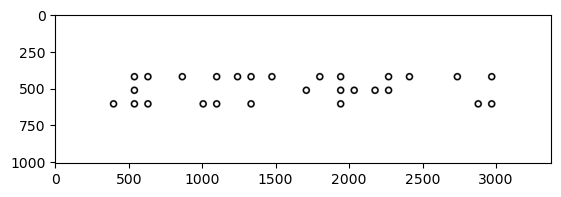


 점자 추출 -> find_braille()


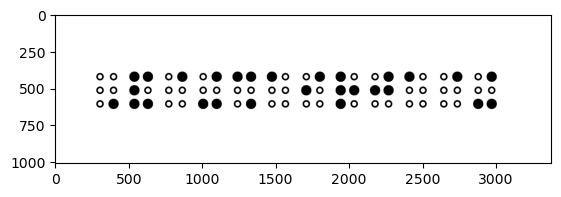

(0, 0, 0, 0, 0, 1)
(1, 1, 1, 1, 0, 1)
(0, 0, 0, 1, 0, 0)
(0, 0, 1, 1, 0, 1)
(1, 0, 0, 1, 0, 1)
(1, 0, 0, 0, 0, 0)
(0, 1, 0, 1, 0, 0)
(1, 1, 1, 0, 1, 0)
(0, 1, 0, 1, 1, 0)
(1, 0, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0)
(0, 0, 1, 1, 0, 1)


In [1]:
# x 좌표가 잘못 수정되는 오류 수정

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)


#     plt.imshow(img)
#     plt.show()

    # 바이너리 이미지 만들기
    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # print('회전 전')
    # plt.imshow(thresh_cv, cmap='gray')
    # plt.show()

    return img, thresh_cv



"""
2번 
resize 조절해야함
  resize 우선 생략했을 때 결과 이상
  아마 이건 3번 문제일듯
blank 크기 조절할 수 있음
"""


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # 중심점 저장 리스트
    center_list = []  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

################################ 1차로 추리기
            
    # blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])


        # center_list.append([num, cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        # cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        # num += 1

    # plt.imshow(blank, cmap = 'gray')
    # plt.show()

    # print(*center_list)
    # center_list = []

############################### 이미지 자르기

    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    # 사진 자르기
    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150].copy()

#     print('자른 사진')
#     plt.imshow(new_img)
#     plt.show()

############################### 이미지 크게 만들기 1. 배경 만들고 붙이기

    pix = new_img[0:1, 0:1]

    # 새로 배경을 만들고, 자른 이미지를 배경의 중앙에 위치하도록

    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 255, dtype='uint8')
    # bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), 0, dtype='uint8')
    bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), pix, dtype='uint8')

    x_offset = (bg.shape[1] - new_img.shape[1]) // 2
    y_offset = (bg.shape[0] - new_img.shape[0]) // 2

    bg[y_offset:y_offset + new_img.shape[0],
       x_offset:x_offset + new_img.shape[1]] = new_img

#     print('자른 사진을 배경에 합치기')
#     plt.imshow(bg)
#     plt.show()


    # 합친 이미지의 배경이 동일하지 않아서 그런가 결과가 제대로 출력되지 않음
    new_img = bg

############################### 이미지 크게 만들기 2. resize ➜ 안쓰는게 나을듯

    # 자른 사진 resize
    # new_img = cv2.resize(new_img, (3337, 1091))   # 크기 정해서 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 140 / ((max_y - min_y) / 2), fy= 140 / ((max_y - min_y) / 2)) # 비율로 resize
    # new_img = cv2.resize(new_img, (0, 0), fx= 1.5, fy= 1.5) # 비율로 resize


    # print('자른 사진 resize')
    # plt.imshow(new_img)
    # plt.show()

############################### 새로운 이미지에서 처음부터 시작


    # 테스트용 리스트
    test = []
    


    # 중심점 초기화
    center = np.empty((0, 2), int) 

    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    # 회전 보정
    thresh_cv = rotate(new_img, thresh_cv)

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
    # blank = np.full([thresh_cv.shape[0] + 200, thresh_cv.shape[1] + 200], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      # if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
      if (cv2.contourArea(i) != 0):  # 면적 기본 조건

        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        test.append([num, cx])
        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        # cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 4, (0, 0, 0), 3)
        cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()
    
    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 5, 6)
    
    # 테스트용 출력
    print('\n')
    print(*test)
      
    return center, center_list, blank



# 2-1
# 회전 보정
def rotate(img, thresh_cv):

    # Hough Transition 회전 보정
    # theta에 제한을 두느냐, 안두느냐에 따라 달라짐
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)
    # lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10)

    # np.sort(lines)[::-1]

    # print('line 개수 = ', len(lines))

    if lines is not None:
        lines = lines.reshape([-1, 2])
        # for line in lines[:]:
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            # hough line 그리는 함수
            # cv2.line(img,(x1,y1),(x2,y2),(255,0,0),2)


        # plt.imshow(img)
        # plt.show()


        # 회전 각도
        # print(lines[:, 1])
        theta_avg = np.average(lines[:10, 1])
        # theta_avg = np.average(lines[:20, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi
        # print('angle : ', angle)


        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)


#         print('회전 후')
#         plt.imshow(thresh_cv, cmap='gray')
#         plt.show()

        return thresh_cv



"""
3번에서 사용하는 메서드들이 중요
여기서 사용하는 모든 수치에 따라 결과가 다르게 나옴
"""



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    # dist= (max(standard_y) - min(standard_y)) // 2
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist


######################################################################## 이 부분 수정 필요
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    x_list = find_x(dist, standard_x)
    
    
    # 테스트용
    # print('dist = ', dist)
    print('\n')
    print('center_x = ', np.sort(center[:, 0]))
    print('\n')
    print('classify_x = ', classify_x)
    print('\n')
    print('standard_x = ', standard_x)
    
    
    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)
    
    
    # 테스트용
    print('\n')
    print('x_list = ', x_list)
    print('\n')
    print('standard_x = ', standard_x)
    
    
    
########################################################################


    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)


    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))


    # 수정 및 정렬된 좌표 표시
    # num = 1

    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
      # cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3.8, (0, 0, 0), 3)
      # num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()


    # 좌표 간격 ( 테스트용 )
    # interval(center_list, blank, 5, 6)

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      # 0.2 는 내가 임의로 정함
      # 같은 점이라고 판단할만한 범위
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2:
        line.append([i])
      else:
        line[-1].append(i)

  # avg = [int(np.average(i)) for i in line]
  # avg = [i[0] for i in line]
  avg = [max(i) for i in line]

  # print('line = ', line)
  # print('avg = ', avg)

  return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  if (standard[1] - standard[0] > standard[2] - standard[1]):
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  i = len(all_x)   # 반복 횟수
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      # 1.55 도 결과에 영향
      # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
      new_x = all_x[-1] + (dist * 1.55)  

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
    # 0.25는 임의로 잡은 숫자
    # if (new_x > standard[-1] - (dist*0.25) and new_x < standard[-1] + (dist*0.25)) or new_x > standard[-1]:
    if new_x > standard[-1] - (dist * 0.25):
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    
  return all_x



"""
3-3 에서 잘못된 좌표로 수정되거나
수정이 안되는 문제로 인해 4번 결과가 이상함
"""

# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
  # 좌표 변화 테스트용
  test = []

  for i in range(len(standard)):
    
    # 테스트용
    inner = []
    inner.append(standard[i])
    inner.append('➜')
    
    
    new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
    num = min(new)
    standard[i] = num + standard[i] if num + standard[i] in x_list else standard[i] - num
    
    
    # 테스트용
    inner.append(standard[i])
    test.append(inner)
    
    
  # 테스트용
  print('\n')  
  print(*test)
    

  return standard




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist




# 3 - 5 ( option )
# 좌표 간격 테스트
def interval(clist, blank, num1, num2):

  test = copy.deepcopy(blank)

  cv2.circle(test, (clist[num1-1][0],  clist[num1-1][1]), 35, (0, 0, 255), -1)
  cv2.circle(test, (clist[num2-1][0],  clist[num2-1][1]), 35, (0, 0, 255), -1)

  plt.imshow(test, cmap = 'gray') 
  plt.show()

  print(num1, ' 의 x 좌표 = ', clist[num1-1][0])
  print(num2, ' 의 x 좌표 = ', clist[num2-1][0])
  # print(num1, ',', num2, ' x좌표 차이 : ', clist[num1-1][0] - clist[num2-1][0])
  # print(num1, ',', num2, ' y좌표 차이 : ', clist[num1-1][1] - clist[num2-1][1])





"""
결과가 좋지 않아도 4번은 웬만하면 문제가 없다
3번에서 잘못된 처리를 해서 4번이 잘못된 결과를 출력
"""


# 4
# 점자 추출
def find_braille(draw, x_list, center_list):

    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])


    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))


    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []


    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)
    

    plt.imshow(draw, cmap = 'gray')
    plt.show()


    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  img, thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list, new = find_location(img, thresh_cv)

  # 흰색 배경
  blank = np.full(new.shape[:], 255, dtype='uint8')
  draw = np.full(new.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\plz4.jpg')  

In [ ]:
# 수정용 코드 ( 주석 제거 )
# 첫 번째 좌표 생성 조건 변경
# 점자 좌표 보정 조건 추가 ( 문제 해결 )

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt


# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)

    plt.imshow(img)
    plt.show()

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center = np.append(center, np.array([[cx, cy]]), axis=0)


    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    # 사진 자르기
    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150].copy()

    pix = new_img[0:1, 0:1]

    # 새로 배경을 만들고, 자른 이미지를 배경의 중앙에 위치하도록
    bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), pix, dtype='uint8')

    x_offset = (bg.shape[1] - new_img.shape[1]) // 2
    y_offset = (bg.shape[0] - new_img.shape[0]) // 2

    bg[y_offset:y_offset + new_img.shape[0],
       x_offset:x_offset + new_img.shape[1]] = new_img

    # 합친 이미지의 배경이 동일하지 않아서 그런가 결과가 제대로 출력되지 않음
    new_img = bg


    ################### 테스트용 리스트
    test = []

    # 중심점 초기화
    center = np.empty((0, 2), int) 
    
    # 중심점 저장 리스트
    center_list = []  

    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    # 회전 보정
    thresh_cv = rotate(new_img, thresh_cv)

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      if (cv2.contourArea(i) != 0):  # 면적 기본 조건

        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        test.append([num, cx])
        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()
    
    
    ####################### 테스트용 출력
    print('\n', *test)
      
    return center, center_list, blank



# 2-1
# 회전 보정
def rotate(img, thresh_cv):

    # Hough Transition 회전 보정
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)

    if lines is not None:
        lines = lines.reshape([-1, 2])
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

        # 회전 각도
        theta_avg = np.average(lines[:10, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi

        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)

        return thresh_cv



####################################################################################################################
####################################################################################################################
####################################################################################################################



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist


######################################################################## 이 부분 수정 필요
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    x_list = find_x(dist, standard_x)
    
    
    # 테스트용
    print('\n', 'dist = ', dist)
    print('\n', 'center_x = ', np.sort(center[:, 0]))
    print('\n', 'classify_x = ', classify_x)
    print('\n', 'standard_x = ', standard_x)
    print('\n', 'x_list = ', x_list)
    
    
    # standard_x 좌표 x_list에 맞게 변경
    standard_x = changeStandard_x(dist, standard_x, x_list)
    
    
########################################################################


    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)
    

    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))

    
    for i in center_list:
      cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
  line = []
  location = np.sort(location)
  for i in location:
      if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2:
        line.append([i])
      else:
        line[-1].append(i)

  avg = [int(np.average(i)) for i in line]
  # avg = [i[0] for i in line]

  return line, avg





"""
3-2 에서 첫 번째 좌표 판단 수정 필요
중간 좌표 간격을 어떻게 설정하는지가 3-3 에 영향을 미치는듯
    있게 되는 문제
3-3 은 지금 가장 편차가 작은 값으로 변경하는걸 기본으로함
    다른 수직선 상의 좌표가 같은 수직선 상의 좌표로 변하는 경우에 대한 처리 추가함
"""


# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard):

  all_x = []

  # 처음 좌표 확인 ( 앞 줄이 비어있는 경우 )
  # 조건 수정 필요 ( 사진마다 다르게 적용될 수도 있음 )
  if standard[1] - standard[0] > dist * 1.5:
      all_x.append(standard[0] - dist)

  else:
      all_x.append(standard[0])


  # 중간 좌표
  i = len(all_x)   # 반복 횟수
  while True:
    if i % 2 == 1:
      new_x = all_x[-1] + dist
    else:
      # 1.55 도 결과에 영향
      # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
      new_x = all_x[-1] + (dist * 1.8)  

    all_x.append(int(new_x))

    i += 1

    # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
    # 0.25는 임의로 잡은 숫자
    if new_x > standard[-1] - (dist * 0.25):
      if i % 2 == 0:
        break
      else:
        all_x.append(int(new_x + dist))
        break

    
  return all_x




# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
  # 변화된 값을 저장할 리스트
  change = []
    
  # 좌표 변화 테스트용
  test = []

  for i in range(len(standard)):
    
    new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
    num = min(new)
    temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
    # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
    if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
        new.remove(num)
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
    change.append(temp)
    
    
    # 테스트용
    test.append([ standard[i], '➜' , change[i] ])
    
    
  # 테스트용
  print('\n', '######################### standard 좌표 변화 #########################')
  print(*test)
    

  return change




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
  for c in range(len(clist)):
    for cl in range(len(classify)):
      if clist[c][i] in classify[cl]:
        clist[c][i] = standard_loc[cl]
        
  return clist





# 4
# 점자 추출
def find_braille(draw, x_list, center_list):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
      for y in y_list:
        if [x, y] not in all_list:
          all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
      if all_list[i] in center_list:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
        overlap.append(1)
      else:
        cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
        overlap.append(0)

    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  
    


def logic(filename):
  # 이미지 전처리
  print('이미지 전처리 -> pre_processing()')
  img, thresh_cv = pre_processing(filename)

  # 점자 좌표 탐색
  print('\n','점자 좌표 탐색 -> find_location()')
  center, center_list, new = find_location(img, thresh_cv)

  # 흰색 배경
  blank = np.full(new.shape[:], 255, dtype='uint8')
  draw = np.full(new.shape[:], 255, dtype='uint8')

  # 점자 좌표 보정
  print('\n','점자 좌표 보정 -> modify_location()')
  x_list, center_list = modify_location(blank, center, center_list)

  # 점자 추출
  print('\n','점자 추출 -> find_braille()')
  braille = find_braille(draw, x_list, center_list)

  # 결과 확인
  print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\test3.jpg')  

In [ ]:
# 점자 리스트의 첫 번째 항목이 첫 번째 줄인지 두 번째 줄인지 판단하는 코드 수정

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)

    plt.imshow(img)
    plt.show()

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center = np.append(center, np.array([[cx, cy]]), axis=0)


    # 면적으로 기본 조건 끝내고 사진 자르기
    min_y = min(center[:, 1]) # 가장 작은 y 값
    max_y = max(center[:, 1])   # 가장 큰 y 값

    min_x = min(center[:, 0]) # 가장 작은 x 값
    max_x = max(center[:, 0])   # 가장 큰 x 값


    # 사진 자르기
    new_img = img[min_y - 150: max_y + 150, min_x - 150: max_x + 150].copy()

    pix = new_img[0:1, 0:1]

    # 새로 배경을 만들고, 자른 이미지를 배경의 중앙에 위치하도록
    bg = np.full((new_img.shape[0] + 500, new_img.shape[1] + 500), pix, dtype='uint8')

    x_offset = (bg.shape[1] - new_img.shape[1]) // 2
    y_offset = (bg.shape[0] - new_img.shape[0]) // 2

    bg[y_offset:y_offset + new_img.shape[0],
       x_offset:x_offset + new_img.shape[1]] = new_img

    # 합친 이미지의 배경이 동일하지 않아서 그런가 결과가 제대로 출력되지 않음
    new_img = bg

    # 중심점 초기화
    center = np.empty((0, 2), int) 
    
    # 중심점 저장 리스트
    center_list = []  

    # 자른 사진으로 처음부터 다시
    ret, thresh_cv = cv2.threshold(new_img, 150, 255, cv2.THRESH_BINARY)

    # 회전 보정
    thresh_cv = rotate(new_img, thresh_cv)

    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      if (cv2.contourArea(i) != 0):  # 면적 기본 조건

        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()
    

    return center, center_list, blank



# 2-1
# 회전 보정
def rotate(img, thresh_cv):

    # Hough Transition 회전 보정
    lines = cv2.HoughLines(thresh_cv, 1, np.pi / 360, 10, min_theta=np.pi*0.3, max_theta=np.pi*0.8)

    if lines is not None:
        lines = lines.reshape([-1, 2])
        for line in lines[:10]:
            rho = line[0]
            theta = line[1]

            a = np.cos(theta)
            b = np.sin(theta)

            x0 = a*rho
            y0 = b*rho

            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))

            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

        # 회전 각도
        theta_avg = np.average(lines[:10, 1])
        angle = (theta_avg - np.pi * 0.5) * 180 / np.pi

        # 회전 ( 정확하게 보정되진 않음 )
        matrix = cv2.getRotationMatrix2D( (img.shape[1] / 2, img.shape[0] / 2), angle, 1)
        thresh_cv = cv2.warpAffine(thresh_cv,matrix,(img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)

        return thresh_cv




# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    dist= (max(center[:, 1]) - min(center[:, 1])) // 2

    # x, y 기준 위치
    classify_x, standard_x = standard(center[:, 0], dist)
    classify_y, standard_y = standard(center[:, 1], dist)
  

    # # y좌표 간격 통일
    standard_y[1] = standard_y[0] + dist
    standard_y[2] = standard_y[1] + dist
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]])
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]])  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist])  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x, y 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    center_list = modify(classify_y, standard_y, center_list, 1)
    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )
def standard(location, dist):
    line = []
    location = np.sort(location)
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > dist * 0.2:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]
    
    return line, avg




# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
        # 1.8 도 결과에 영향
        # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
            new_x = all_x[-1] + (dist * 1.8)  

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        # 0.25는 임의로 잡은 숫자
        if new_x > standard[-1] - (dist * 0.25):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    for i in range(len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change




# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist





# 4
# 점자 추출
def find_braille(draw, x_list, center_list):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    braille = [tuple(i) for i in temp]

    return braille
  
    


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list = modify_location(blank, center, center_list)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = find_braille(draw, x_list, center_list)

    # 결과 확인
    print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\final.jpg')  
# logic('C:\\Users\\HwaJong\\Desktop\\test\\plz4.jpg')   # 3-2에서 중간좌표 구할 때 1.55 로 하면 정상 작동함

In [ ]:
# 여러 줄의 점자도 인식 가능하도록 수정 및 회전 보정 제거 ( 추후 추가 예정 )

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)

    plt.imshow(img)
    plt.show()

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = standard_y[1] - standard_y[0]  
    
    # y좌표 간격 통일
    for i in range(0, len(standard_y), 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
        
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1)    
    
    
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]])
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]])  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist])  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)
    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 30:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
        # 1.8 도 결과에 영향
        # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
            new_x = all_x[-1] + (dist * 1.8)  

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        # 0.25는 임의로 잡은 숫자
        if new_x > standard[-1] - (dist * 0.25):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    for i in range(len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist





# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

#     plt.imshow(draw, cmap = 'gray')
#     plt.show()

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')


logic('C:\\Users\\HwaJong\\Desktop\\test\\combine.jpg')  

In [ ]:
# 점자가 완전하지 않게 촬영된 좌표를 제거

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)

    plt.imshow(img)
    plt.show()

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      if (cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0):  # 면적 기본 조건
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        print(cut_idx)
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]])
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]])  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist])  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 30:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
        # 1.8 도 결과에 영향
        # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
            new_x = all_x[-1] + (dist * 1.7)  

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        # 0.25는 임의로 잡은 숫자
        if new_x > standard[-1] - (dist * 0.25):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    for i in range(len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist





# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

#     plt.imshow(draw, cmap = 'gray')
#     plt.show()

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')


logic('C:\\Users\\HwaJong\\Desktop\\test\\3_2.jpg')  

In [ ]:
# 점자가 완전하지 않게 촬영된 좌표를 제거

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
      if cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0:
        M = cv2.moments(i)

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        center_list.append([cx, cy])
        center = np.append(center, np.array([[cx, cy]]), axis=0)

        cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        print(cut_idx)
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]])
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]])  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist])  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 30:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
        # 1.8 도 결과에 영향
        # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
            new_x = all_x[-1] + (dist * 1.7)  

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        # 0.25는 임의로 잡은 숫자
        if new_x > standard[-1] - (dist * 0.25):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    for i in range(len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist





# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

#     plt.imshow(draw, cmap = 'gray')
#     plt.show()

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')


logic('C:\\Users\\HwaJong\\Desktop\\test\\3_2.jpg')  

In [ ]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    
    plt.imshow(thresh_cv, cmap = 'gray')
    plt.show()

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
        if cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0:
            M = cv2.moments(i)

            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            center_list.append([cx, cy])
            center = np.append(center, np.array([[cx, cy]]), axis=0)

            cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
            cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
            num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]])
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]])  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist])  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 30:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
        # 1.8 도 결과에 영향
        # 이 숫자가 점자 사이의 간격을 의미하는데 간격이 커질 수록 나중에 standard 를 바꿀 때 잘못된 값으로 바뀜
            new_x = all_x[-1] + (dist * 1.9)  

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        # 0.25는 임의로 잡은 숫자
        if new_x > standard[-1] - (dist * 0.25):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    for i in range(len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist





# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')


logic('C:\\Users\\HwaJong\\Desktop\\test\\test2.jpg')  

이미지 전처리 -> pre_processing()


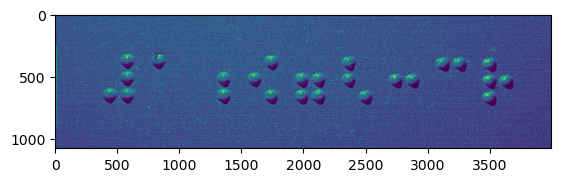

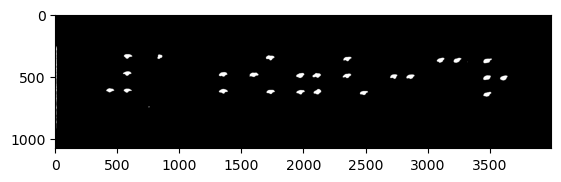


 점자 좌표 탐색 -> find_location()


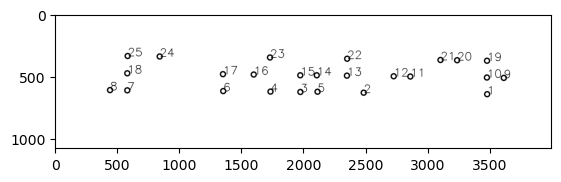


 점자 좌표 보정 -> modify_location()


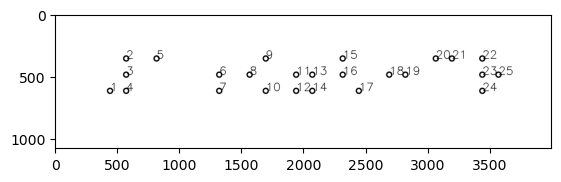


 점자 추출 -> find_braille()


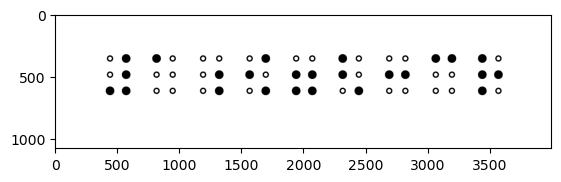

(0, 0, 1, 1, 1, 1)
(1, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 1, 1)
(0, 1, 0, 1, 0, 1)
(0, 1, 1, 0, 1, 1)
(1, 1, 0, 0, 0, 1)
(0, 1, 0, 0, 1, 0)
(1, 0, 0, 1, 0, 0)
(1, 1, 1, 0, 1, 0)


In [1]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    
    plt.imshow(thresh_cv, cmap = 'gray')
    plt.show()

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
        if cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0:  
            M = cv2.moments(i)

            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            center_list.append([cx, cy])
            center = np.append(center, np.array([[cx, cy]]), axis=0)

            cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
            cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
            num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 점자 간의 간격 구하기
    test = [abs(standard_x[i] - standard_x[i+1]) for i in range(len(standard_x) - 1) \
            if abs(standard_x[i] - standard_x[i+1]) > dist * 1.3]
    
    cls, std = standard(np.array(test))
    
    inter = std[0]  # 점자 간의 간격
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]], inter)
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]], inter)  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist], inter)  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    num = 1
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 30:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x, inter):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
            new_x = all_x[-1] + inter

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        if new_x > standard[-1] - (dist * 0.7):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    new = [abs(j - standard[0]) for j in x_list]  # 편차 리스트
    num = min(new)
    temp = num + standard[0] if num + standard[0] in x_list else standard[0] - num
    change.append(temp)

    for i in range(1, len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist




# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\test\\test2.jpg')  

In [ ]:
# 점자 간의 간격 구하는 알고리즘 추가

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    
    plt.imshow(thresh_cv, cmap = 'gray')
    plt.show()

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
        # if cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0:  
        if cv2.contourArea(i) > 100:
            M = cv2.moments(i)

            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            center_list.append([cx, cy])
            center = np.append(center, np.array([[cx, cy]]), axis=0)

            cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
            cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
            num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 점자 간의 간격 구하기
    test = [abs(standard_x[i] - standard_x[i+1]) for i in range(len(standard_x) - 1) \
            if abs(standard_x[i] - standard_x[i+1]) >= dist]
    
    cls, std = standard(np.array(test))
    
    inter = std[1]  # 점자 간의 간격
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]], inter)
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]], inter)  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist], inter)  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    num = 1
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)
        cv2.putText(blank, str(num), (i[0], i[1]), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
        num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 150:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [i[-1] for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x, inter):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
            new_x = all_x[-1] + inter

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        if new_x > standard[-1] - (dist * 0.7):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    new = [abs(j - standard[0]) for j in x_list]  # 편차 리스트
    num = min(new)
    temp = num + standard[0] if num + standard[0] in x_list else standard[0] - num
    change.append(temp)

    for i in range(1, len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist




# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\good\\image1.jpg')  

In [ ]:
# 점자 간의 간격 구하기 수정

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
    
    plt.imshow(thresh_cv, cmap = 'gray')
    plt.show()

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
        # if cv2.contourArea(i) > 100 and cv2.contourArea(i) < 2000 and cv2.contourArea(i) != 0:  
        if cv2.contourArea(i) > 100:
            M = cv2.moments(i)

            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            center_list.append([cx, cy])
            center = np.append(center, np.array([[cx, cy]]), axis=0)

            cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
            cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
            num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 점자 간의 간격 구하기
    test = [abs(standard_x[i] - standard_x[i+1]) for i in range(len(standard_x) - 1) \
            if abs(standard_x[i] - standard_x[i+1])]
    
    cls, std = standard(np.array(test))
    
    inter = std[1]  # 점자 간의 간격
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]], inter)
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]], inter)  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist], inter)  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 200:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x, inter):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
            new_x = all_x[-1] + inter

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        if new_x > standard[-1] - (dist * 0.7):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    new = [abs(j - standard[0]) for j in x_list]  # 편차 리스트
    num = min(new)
    temp = num + standard[0] if num + standard[0] in x_list else standard[0] - num
    change.append(temp)

    for i in range(1, len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist




# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\ektks\\save.jpg')  

In [ ]:
# Contour 면적 조건, 이진화 임계값 변경

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

# 1
# 이미지 전처리
def pre_processing(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 100, 11, 21)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    ret, thresh_cv = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    
    plt.imshow(thresh_cv, cmap = 'gray')
    plt.show()

    return img, thresh_cv


# 2
# 점자 좌표 탐색
def find_location(img, thresh_cv):  

    # 중심점 저장 ndarray
    center = np.empty((0, 2), int)  
    
    # 중심점 저장 리스트
    center_list = []  
    
    # Contour
    contours, hierarchies = cv2.findContours(thresh_cv, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # 흰색 배경
    blank = np.full(thresh_cv.shape[:], 255, dtype='uint8')
 
    # 점자 번호
    num = 1
            
    for i in contours:
        if cv2.contourArea(i) > 500:
            M = cv2.moments(i)

            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            center_list.append([cx, cy])
            center = np.append(center, np.array([[cx, cy]]), axis=0)

            cv2.circle(blank, (cx, cy), 20, (0, 0, 0), 10)
            cv2.putText(blank, str(num), (cx, cy), cv2.FONT_ITALIC, 3, (0, 0, 0), 3)
            num += 1

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return center, center_list, blank



# 3
# 점자 좌표 보정
def modify_location(blank, center, center_list):
    
    # y 좌표
    # y 기준 위치
    classify_y, standard_y = standard(center[:, 1])
    
    # 점자 거리 구하기
    dist = 9999
    for i in range(len(standard_y) - 1):
        if dist > standard_y[i + 1] - standard_y[i]:
            dist = standard_y[i + 1] - standard_y[i]
    
    
    # standard_y에서 완전하지 않은 점자의 y 좌표 제거
    cut_idx = [standard_y[0]]  # new_standard 에 들어갈 좌표 후보 리스트
    new_standard = []
    cnt = 1
    for i in range(1, len(standard_y)):
        # 아직 standard 의 간격이 통일되지 않았기 때문에 1.3를 곱한다
        if standard_y[i] - standard_y[i - 1] < dist * 1.3:
            cut_idx.append(standard_y[i])
            cnt += 1
            
            if cnt == 3:
                new_standard.extend(cut_idx)
                cut_idx.clear()
                cnt = 0
            
        else:
            if cnt != 3:
                cut_idx.clear()
                cut_idx.append(standard_y[i])
                cnt = 1



    # classify_y 에서 필요없는 좌표 제거
    rm_center = []  # center_list 에서 제거해야할 y 좌표가 들어있는 리스트
    new_classify = []
    for i in range(len(standard_y)):
        if standard_y[i] not in new_standard:
            rm_center.extend(classify_y[i])
        else:
            new_classify.append(classify_y[i])
            
            
    # center_list에서 완전하지 않은 점자의 좌표 제거
    new_center = []
    for i in range(len(center_list)):
        if center_list[i][1] not in rm_center:
            new_center.append(center_list[i])
        
    
    # 완전하지 않은 점자들을 제거한 리스트를 원본으로 사용
    classify_y = new_classify
    standard_y = new_standard
    center_list = new_center


    # y좌표 간격 통일
    standard_y.sort()
    for i in range(0, (len(standard_y) // 3) * 3, 3):
        standard_y[i+1] = standard_y[i] + dist
        standard_y[i+2] = standard_y[i] + dist * 2
    
    
    # y 좌표 기준값으로 수정
    center_list = modify(classify_y, standard_y, center_list, 1) 
    
    
################# x 좌표
    
    # x 좌표 동일 작업
    classify_x, standard_x = standard(center[:, 0])
    
    # 점자 간의 간격 구하기
    test = [abs(standard_x[i] - standard_x[i+1]) for i in range(len(standard_x) - 1) \
            if abs(standard_x[i] - standard_x[i+1])]
    
    cls, std = standard(np.array(test))
    
    inter = std[1]  # 점자 간의 간격
    
    
    # 가능한 모든 x 좌표 구하기 +  x 좌표 간격 일정하게
    # 첫 번째 줄과 두 번째 줄이 모두 있는 경우
    if standard_x[1] - standard_x[0] < 1.2 * dist:
        x_list = find_x(dist, standard_x, [standard_x[0]], inter)
        standard_x = changeStandard_x(dist, standard_x, x_list) # standard_x 좌표를 x_list에 맞게 변경

    else:
        one = find_x(dist, standard_x, [standard_x[0]], inter)  # 0 번째 항목이 첫 번째 줄인 경우
        one_standard = changeStandard_x(dist, standard_x, one)  # standard_x 좌표 변경
        one_max = max([abs(standard_x[i] - one_standard[i]) for i in range(len(one_standard))])   # 기존 standard_x 와 바뀐 standard_x 의 차이의 최댓값
        
        two = find_x(dist, standard_x, [standard_x[0] - dist], inter)  # 두 번째 줄인 경우
        two_standard = changeStandard_x(dist, standard_x, two)  # standard_x 좌표 변경
        two_max = max([abs(standard_x[i] - two_standard[i]) for i in range(len(two_standard))])
        
        # 기존 standard_x 와 변한 standard_x 의 차이가 적은 것을 선택
        if one_max < two_max:
            x_list = one
            standard_x = one_standard
        else:
            x_list = two
            standard_x = two_standard
            

    # x 좌표 수정
    center_list = modify(classify_x, standard_x, center_list, 0)

    
    # 좌표 정렬
    center_list = sorted(center_list, key=lambda i: (i[0], i[1]))
    
    for i in center_list:
        cv2.circle(blank, (i[0], i[1]), 20, (0, 0, 0), 10)

    plt.imshow(blank, cmap = 'gray')
    plt.show()

    return x_list, center_list, dist




# 3 - 1
# 기준 위치 구하기 ( 좌표 보정할 기준 좌표 )

def standard(location):
    line = []
    location = np.sort(location)
    
    for i in location:
        if len(line) == 0 or i - np.average(line[-1]) > 200:
            line.append([i])
        else:
            line[-1].append(i)
            
    avg = [int(np.average(i)) for i in line]

    return line, avg



# 3 - 2
# 전체 x 좌표 찾기
def find_x(dist, standard, all_x, inter):

    # 중간 좌표
    i = len(all_x)   # 반복 횟수
    while True:
        if i % 2 == 1:
            new_x = all_x[-1] + dist
        else:
            new_x = all_x[-1] + inter

        all_x.append(int(new_x))

        i += 1

        # 마지막 좌표 ( 중간 좌표 생성 종료 조건 )
        if new_x > standard[-1] - (dist * 0.7):
            if i % 2 == 0:
                break
            else:
                all_x.append(int(new_x + dist))
                break

    return all_x



# 3 - 3
# standard_x를 전체 x 좌표에 맞게 변경하는 메서드
# standard를 x_list와 편차가 가장 작은 숫자로 변경
def changeStandard_x(dist, standard, x_list):
    
    # 변화된 값을 저장할 리스트
    change = []

    new = [abs(j - standard[0]) for j in x_list]  # 편차 리스트
    num = min(new)
    temp = num + standard[0] if num + standard[0] in x_list else standard[0] - num
    change.append(temp)

    for i in range(1, len(standard)):
        new = [abs(j - standard[i]) for j in x_list]  # 편차 리스트
        num = min(new)
        temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        # 이전 좌표와 현재 좌표가 같은 수직선 상에 있는 좌표가 아닌데 동일한 값으로 변경되는 경우
        if (standard[i] - standard[i - 1]) > dist * 0.5 and temp == change[i - 1]:
            new.remove(num)
            num = min(new)
            temp = num + standard[i] if num + standard[i] in x_list else standard[i] - num
        change.append(temp)

    return change



# 3 - 4
# center_list 좌표 수정하기
def modify(classify, standard_loc, clist, i):
    for c in range(len(clist)):
        for cl in range(len(classify)):
            if clist[c][i] in classify[cl]:
                clist[c][i] = standard_loc[cl]

    return clist




# 4
# 점자 추출
def find_braille(draw, x_list, center_list, dist, braille):
    
    # x, y 좌표 결합한 좌표 만들기 ( 모든 x에 대한 모든 y 조합 )
    y_list = [i[1] for i in center_list]
    all_list = []
    for x in x_list:
        for y in y_list:
            if [x, y] not in all_list:
                all_list.append([x, y])

    # 좌표 정렬
    all_list = sorted(all_list, key=lambda i: (i[0], i[1]))

    # 점자 위치에 점자가 있는지 ( 겹치는지 여부 )
    overlap = []

    # 해당 위치에 점자가 있는지 추출 및 그리기 ( 있으면 1, 없으면 0 )
    for i in range(len(all_list)):
        if all_list[i] in center_list:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 35, (0, 0, 0), -1)
            overlap.append(1)
        else:
            cv2.circle(draw, (all_list[i][0],  all_list[i][1]), 20, (0, 0, 0), 10)
            overlap.append(0)

    # 점자 6개씩 끊어서 튜플로 변환
    temp = [overlap[i * 6:(i + 1) * 6] for i in range((len(overlap) - 1 + 6) // 6 )] 

    for i in temp:
        braille.append(tuple(i)) 
    
    
# 4 - 1
# 점자 단락 나누기
def split_loc(location, dist):
    line = []
    location.sort(key = lambda x : x[1])
    
    for i in location:
        if len(line) == 0 or i[1] > line[-1][0][1] + 2 * dist:
            line.append([i])
        else:
            line[-1].append(i)

    return line


def logic(filename):
    # 이미지 전처리
    print('이미지 전처리 -> pre_processing()')
    img, thresh_cv = pre_processing(filename)

    # 점자 좌표 탐색
    print('\n','점자 좌표 탐색 -> find_location()')
    center, center_list, new = find_location(img, thresh_cv)

    # 흰색 배경
    blank = np.full(new.shape[:], 255, dtype='uint8')
    draw = np.full(new.shape[:], 255, dtype='uint8')

    # 점자 좌표 보정
    print('\n','점자 좌표 보정 -> modify_location()')
    x_list, center_list, dist = modify_location(blank, center, center_list)
    
    # y 좌표에 따라 분할하기 ( 몇 번째 단락인지 )
    split_list = split_loc(center_list, dist)

    # 점자 추출
    print('\n','점자 추출 -> find_braille()')
    braille = []
    for sl in split_list:
        find_braille(draw, x_list, sl, dist, braille)
        
    plt.imshow(draw, cmap = 'gray')
    plt.show()

    # 결과 확인
    print(*braille, sep = '\n')



logic('C:\\Users\\HwaJong\\Desktop\\edit\\result.jpg')  